# Revenue Forecasting ML Pipeline - Production Optimized
## Ridge, Lasso & ElasticNet with Advanced Imputation & Feature Engineering

---

### 🎯 Problem Understanding:

**CRITICAL UNDERSTANDING:**
- `wtd_pipeline_revenue`, `committed_unsig_revenue`, `committed_sign_revenue` are CUMULATIVE FORECAST columns
- They DECREASE as we approach December within each year (remaining opportunity shrinks)
- `actual_revenue` can increase or decrease each month (monthly revenue)
- `avg_prob_pct` is a probability/guess column - can only multiply other columns or create lag/rolling features
- NO cross-year data leakage in imputation

**Data Split:**
- Training: 2023 & 2024 (all months)
- Testing: 2025 (9 months)

---

### 📋 Pipeline:

1. Data Imputation FIRST → Respecting DECREASING cumulative nature
2. Feature Engineering → Domain-specific features
3. Multicollinearity Check → Remove redundant features
4. Feature Selection → Ensemble voting
5. Model Training → Ridge, Lasso, ElasticNet with extended tuning

---
## STEP 1: Import Libraries

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-v0_8-whitegrid')
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression, RFE, SelectFromModel
from sklearn.linear_model import Ridge, Lasso, ElasticNet, RidgeCV, LassoCV, ElasticNetCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from scipy.interpolate import interp1d

print("✓ All libraries imported successfully")

✓ All libraries imported successfully


---
## STEP 2: Load Data

In [2]:
df = pd.read_csv('monthly.csv')

print("="*70)
print("DATA OVERVIEW")
print("="*70)
print(f"Shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nMissing Values:\n{df.isnull().sum()}")
df.head(15)

DATA OVERVIEW
Shape: (33, 8)

Columns: ['year', 'month', 'month_num', 'actual_revenue', 'wtd_pipeline_revenue', 'committed_unsig_revenue', 'committed_sign_revenue', 'avg_prob_pct']

Missing Values:
year                       0
month                      0
month_num                  0
actual_revenue             0
wtd_pipeline_revenue       4
committed_unsig_revenue    4
committed_sign_revenue     4
avg_prob_pct               3
dtype: int64


,year,month,month_num,actual_revenue,wtd_pipeline_revenue,committed_unsig_revenue,committed_sign_revenue,avg_prob_pct
0,2023,Mar,3,1.436527e+08,1.494989e+08,2.253415e+08,8.923331e+08,1.08
1,2023,Apr,4,1.248860e+08,1.280212e+08,1.751095e+08,8.463894e+08,0.30
2,2023,May,5,1.388757e+08,1.111832e+08,1.367081e+08,7.942822e+08,0.32
3,2023,Jun,6,1.412344e+08,1.017492e+08,1.290108e+08,6.783522e+08,0.23
4,2023,Jul,7,1.296316e+08,7.002291e+07,1.208822e+08,5.991203e+08,0.24
5,2023,Aug,8,1.367867e+08,5.346090e+07,7.962430e+07,5.398743e+08,0.23
6,2023,Sept,9,1.445525e+08,3.288204e+07,6.513925e+07,4.439887e+08,0.20
7,2023,Oct,10,1.347114e+08,1.492118e+07,5.454807e+07,3.382897e+08,0.19
8,2023,Nov,11,1.391834e+08,7.408017e+06,3.093648e+07,2.376370e+08,0.17
9,2023,Dec,12,1.401632e+08,NaN,NaN,NaN,0.11


In [3]:
# Create date index
df_monthly = df.copy()

month_map = {'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6,
             'Jul': 7, 'Aug': 8, 'Sept': 9, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12}

if 'month' in df_monthly.columns:
    df_monthly['month_num_parsed'] = df_monthly['month'].map(month_map)
    if df_monthly['month_num_parsed'].isnull().any():
        df_monthly['month_num_parsed'] = df_monthly['month_num']
else:
    df_monthly['month_num_parsed'] = df_monthly['month_num']

df_monthly['date'] = pd.to_datetime(
    df_monthly['year'].astype(str) + '-' + df_monthly['month_num_parsed'].astype(str) + '-01'
)
df_monthly = df_monthly.sort_values('date').reset_index(drop=True)

print(f"Date range: {df_monthly['date'].min()} to {df_monthly['date'].max()}")
print(f"2023: {len(df_monthly[df_monthly['year']==2023])} rows")
print(f"2024: {len(df_monthly[df_monthly['year']==2024])} rows")
print(f"2025: {len(df_monthly[df_monthly['year']==2025])} rows")

Date range: 2023-03-01 00:00:00 to 2025-11-01 00:00:00
2023: 10 rows
2024: 12 rows
2025: 11 rows


---
## STEP 3: ADVANCED NULL VALUE IMPUTATION

### 🧠 CRITICAL: DECREASING Cumulative Columns

- `wtd_pipeline_revenue`, `committed_unsig_revenue`, `committed_sign_revenue` are cumulative forecast
- They ALWAYS DECREASE as we progress through the year: March > April > ... > December
- For December: Use decay from November (very small remaining)
- For Jan/Feb: Extrapolate BACKWARD from March (values should be HIGHER)
- NO cross-year data mixing

UNDERSTANDING DECREASING PATTERN OF CUMULATIVE COLUMNS


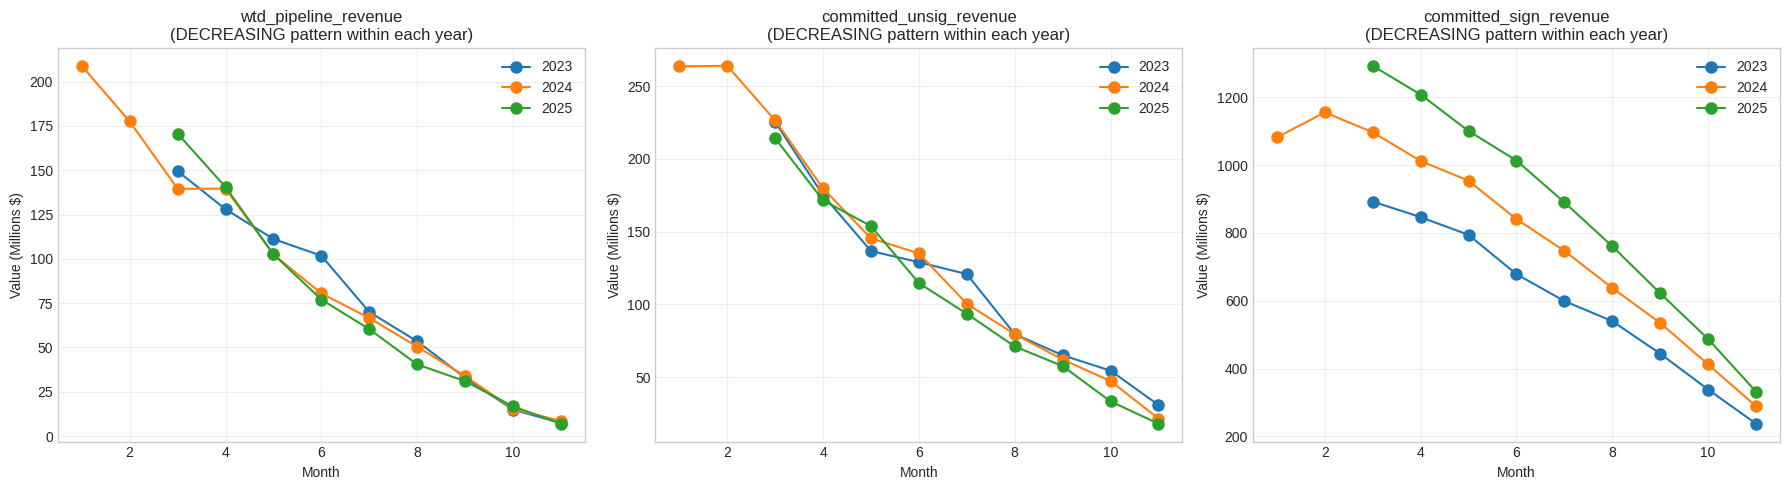


📊 Month-over-Month Decay Rates:
  wtd_pipeline_revenue - 2023: Avg MoM change = -29.3%
  wtd_pipeline_revenue - 2024: Avg MoM change = -25.8%
  wtd_pipeline_revenue - 2025: Avg MoM change = -31.5%
  committed_unsig_revenue - 2023: Avg MoM change = -21.0%
  committed_unsig_revenue - 2024: Avg MoM change = -20.7%
  committed_unsig_revenue - 2025: Avg MoM change = -25.6%
  committed_sign_revenue - 2023: Avg MoM change = -14.8%
  committed_sign_revenue - 2024: Avg MoM change = -11.8%
  committed_sign_revenue - 2025: Avg MoM change = -15.2%


In [4]:
print("="*70)
print("UNDERSTANDING DECREASING PATTERN OF CUMULATIVE COLUMNS")
print("="*70)

cumulative_cols = ['wtd_pipeline_revenue', 'committed_unsig_revenue', 'committed_sign_revenue']

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for idx, col in enumerate(cumulative_cols):
    ax = axes[idx]
    for year in [2023, 2024, 2025]:
        year_data = df_monthly[df_monthly['year'] == year]
        ax.plot(year_data['month_num_parsed'], year_data[col] / 1e6, 'o-', label=f'{year}', markersize=8)
    ax.set_xlabel('Month')
    ax.set_ylabel('Value (Millions $)')
    ax.set_title(f'{col}\n(DECREASING pattern within each year)')
    ax.legend()
    ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Show decay rates
print("\n📊 Month-over-Month Decay Rates:")
for col in cumulative_cols:
    for year in [2023, 2024, 2025]:
        year_data = df_monthly[(df_monthly['year'] == year) & df_monthly[col].notna()].sort_values('month_num_parsed')
        if len(year_data) >= 2:
            pct_changes = year_data[col].pct_change().dropna()
            avg_decay = pct_changes.mean()
            print(f"  {col} - {year}: Avg MoM change = {avg_decay*100:.1f}%")

In [5]:
print("\n" + "="*70)
print("IMPUTATION FOR DECREASING CUMULATIVE COLUMNS")
print("="*70)

df_imputed = df_monthly.copy()

def impute_decreasing_cumulative(df, col_name):
    """
    Impute DECREASING cumulative columns.
    Values DECREASE as we approach December within each year.
    """
    result = df.copy()

    for year in result['year'].unique():
        year_mask = result['year'] == year
        year_data = result[year_mask].sort_values('month_num_parsed')
        available_data = year_data[year_data[col_name].notna()].sort_values('month_num_parsed')

        if len(available_data) < 2:
            continue

        # Calculate decay rate (should be negative)
        pct_changes = available_data[col_name].pct_change().dropna()
        avg_decay_rate = pct_changes.mean()
        if avg_decay_rate > 0:
            avg_decay_rate = -0.20  # Default 20% decrease per month

        missing_rows = year_data[year_data[col_name].isnull()]

        for idx in missing_rows.index:
            month = result.loc[idx, 'month_num_parsed']

            # DECEMBER: Very small remaining (approaching year end)
            if month == 12:
                nov_data = year_data[year_data['month_num_parsed'] == 11]
                if len(nov_data) > 0 and pd.notna(nov_data[col_name].values[0]):
                    nov_val = nov_data[col_name].values[0]
                    result.loc[idx, col_name] = max(0, nov_val * 0.35)  # 35% of Nov
                else:
                    last_avail = available_data.iloc[-1]
                    months_forward = 12 - last_avail['month_num_parsed']
                    projected = last_avail[col_name] * ((1 + avg_decay_rate) ** months_forward)
                    result.loc[idx, col_name] = max(0, projected)

            # JANUARY: Highest value (extrapolate backward)
            elif month == 1:
                first_avail = available_data.iloc[0]
                months_back = first_avail['month_num_parsed'] - 1
                backward_multiplier = 1 / (1 + avg_decay_rate)  # > 1
                projected = first_avail[col_name] * (backward_multiplier ** months_back)
                result.loc[idx, col_name] = projected

            # FEBRUARY: Second highest
            elif month == 2:
                jan_data = result[(result['year'] == year) & (result['month_num_parsed'] == 1)]
                if len(jan_data) > 0 and pd.notna(jan_data[col_name].values[0]):
                    jan_val = jan_data[col_name].values[0]
                    result.loc[idx, col_name] = jan_val * (1 + avg_decay_rate)
                else:
                    first_avail = available_data.iloc[0]
                    months_back = first_avail['month_num_parsed'] - 2
                    backward_multiplier = 1 / (1 + avg_decay_rate)
                    projected = first_avail[col_name] * (backward_multiplier ** months_back)
                    result.loc[idx, col_name] = projected

            # OTHER: Interpolate
            else:
                before_data = available_data[available_data['month_num_parsed'] < month]
                after_data = available_data[available_data['month_num_parsed'] > month]

                if len(before_data) > 0 and len(after_data) > 0:
                    before_row = before_data.iloc[-1]
                    after_row = after_data.iloc[0]
                    month_diff = after_row['month_num_parsed'] - before_row['month_num_parsed']
                    value_diff = after_row[col_name] - before_row[col_name]
                    slope = value_diff / month_diff
                    months_from_before = month - before_row['month_num_parsed']
                    result.loc[idx, col_name] = max(0, before_row[col_name] + slope * months_from_before)
                elif len(before_data) > 0:
                    last_before = before_data.iloc[-1]
                    months_forward = month - last_before['month_num_parsed']
                    result.loc[idx, col_name] = max(0, last_before[col_name] * ((1 + avg_decay_rate) ** months_forward))

    return result

for col in cumulative_cols:
    before = df_imputed[col].isnull().sum()
    df_imputed = impute_decreasing_cumulative(df_imputed, col)
    after = df_imputed[col].isnull().sum()
    print(f"  ✓ {col}: {before} → {after} missing")


IMPUTATION FOR DECREASING CUMULATIVE COLUMNS
  ✓ wtd_pipeline_revenue: 4 → 0 missing
  ✓ committed_unsig_revenue: 4 → 0 missing
  ✓ committed_sign_revenue: 4 → 0 missing


In [6]:
print("\n" + "="*70)
print("IMPUTATION FOR avg_prob_pct (Probability Column)")
print("="*70)
print("💡 avg_prob_pct is a GUESS column - use same-month median")

def impute_probability(df, col_name='avg_prob_pct'):
    result = df.copy()
    month_medians = result.groupby('month_num_parsed')[col_name].median()
    overall_median = result[col_name].median()

    for idx in result[result[col_name].isnull()].index:
        month = result.loc[idx, 'month_num_parsed']
        if month in month_medians.index and pd.notna(month_medians[month]):
            result.loc[idx, col_name] = month_medians[month]
        else:
            result.loc[idx, col_name] = overall_median
    return result

before = df_imputed['avg_prob_pct'].isnull().sum()
df_imputed = impute_probability(df_imputed)
after = df_imputed['avg_prob_pct'].isnull().sum()
print(f"  ✓ avg_prob_pct: {before} → {after} missing")


IMPUTATION FOR avg_prob_pct (Probability Column)
💡 avg_prob_pct is a GUESS column - use same-month median
  ✓ avg_prob_pct: 3 → 0 missing



IMPUTATION VALIDATION
Final missing: 0

✅ All missing values imputed!


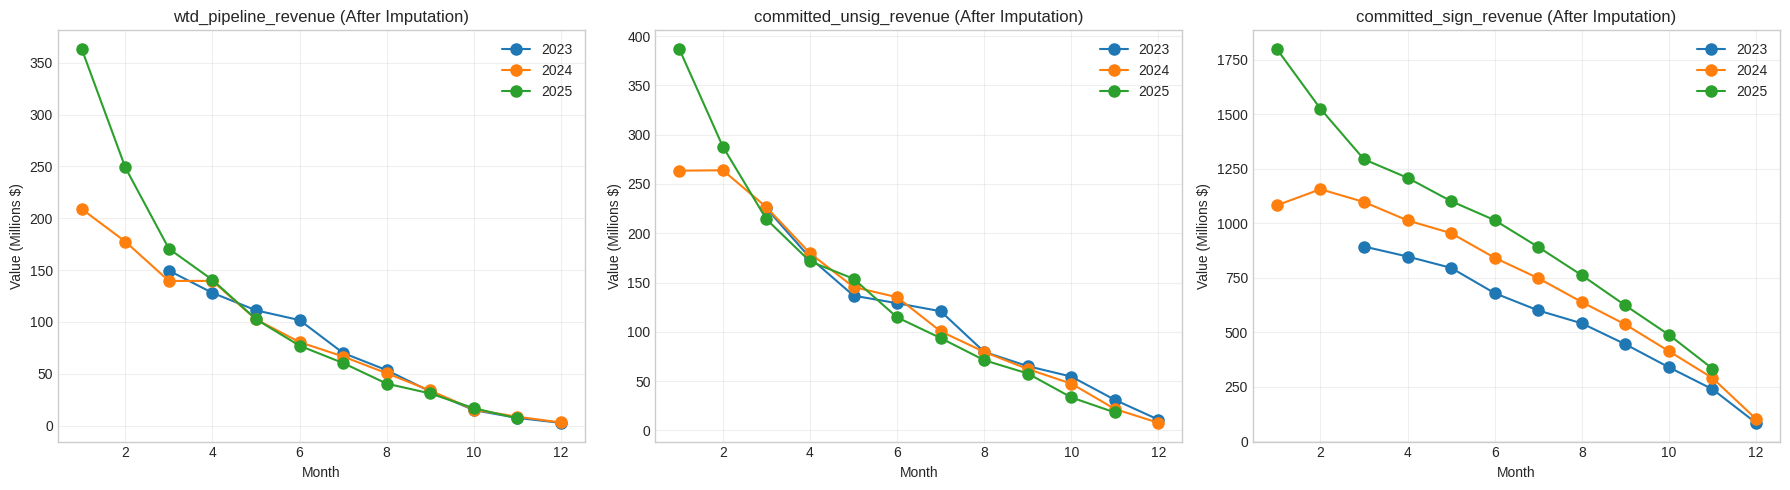


📋 Imputed Values:

2023-Dec:
  wtd_pipeline_revenue: 2,592,805.83 (IMPUTED)
  committed_unsig_revenue: 10,827,769.23 (IMPUTED)
  committed_sign_revenue: 83,172,955.94 (IMPUTED)

2024-Dec:
  wtd_pipeline_revenue: 2,982,354.42 (IMPUTED)
  committed_unsig_revenue: 7,586,458.37 (IMPUTED)
  committed_sign_revenue: 101,131,411.36 (IMPUTED)
  avg_prob_pct: 0.11 (IMPUTED)

2025-Jan:
  wtd_pipeline_revenue: 363,265,924.42 (IMPUTED)
  committed_unsig_revenue: 386,945,658.00 (IMPUTED)
  committed_sign_revenue: 1,798,318,220.59 (IMPUTED)
  avg_prob_pct: 0.24 (IMPUTED)

2025-Feb:
  wtd_pipeline_revenue: 248,973,989.18 (IMPUTED)
  committed_unsig_revenue: 287,893,995.36 (IMPUTED)
  committed_sign_revenue: 1,524,541,778.78 (IMPUTED)
  avg_prob_pct: 0.24 (IMPUTED)


In [7]:
print("\n" + "="*70)
print("IMPUTATION VALIDATION")
print("="*70)

final_missing = df_imputed[cumulative_cols + ['avg_prob_pct']].isnull().sum()
print(f"Final missing: {final_missing.sum()}")

if final_missing.sum() == 0:
    print("\n✅ All missing values imputed!")

# Verify decreasing pattern
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for idx, col in enumerate(cumulative_cols):
    ax = axes[idx]
    for year in [2023, 2024, 2025]:
        year_data = df_imputed[df_imputed['year'] == year].sort_values('month_num_parsed')
        ax.plot(year_data['month_num_parsed'], year_data[col] / 1e6, 'o-', label=f'{year}', markersize=8)
    ax.set_xlabel('Month')
    ax.set_ylabel('Value (Millions $)')
    ax.set_title(f'{col} (After Imputation)')
    ax.legend()
    ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print imputed values
print("\n📋 Imputed Values:")
imputed_mask = df_monthly.isnull().any(axis=1)
for _, row in df_monthly[imputed_mask][['year', 'month', 'month_num_parsed']].iterrows():
    year, month, month_num = int(row['year']), row['month'], int(row['month_num_parsed'])
    imp = df_imputed[(df_imputed['year'] == year) & (df_imputed['month_num_parsed'] == month_num)]
    print(f"\n{year}-{month}:")
    for col in cumulative_cols + ['avg_prob_pct']:
        orig = df_monthly[(df_monthly['year'] == year) & (df_monthly['month_num_parsed'] == month_num)][col].values[0]
        if pd.isna(orig):
            print(f"  {col}: {imp[col].values[0]:,.2f} (IMPUTED)")

In [8]:
df_imputed

,year,month,month_num,actual_revenue,wtd_pipeline_revenue,committed_unsig_revenue,committed_sign_revenue,avg_prob_pct,month_num_parsed,date
0,2023,Mar,3,1.436527e+08,1.494989e+08,2.253415e+08,8.923331e+08,1.08,3,2023-03-01
1,2023,Apr,4,1.248860e+08,1.280212e+08,1.751095e+08,8.463894e+08,0.30,4,2023-04-01
2,2023,May,5,1.388757e+08,1.111832e+08,1.367081e+08,7.942822e+08,0.32,5,2023-05-01
3,2023,Jun,6,1.412344e+08,1.017492e+08,1.290108e+08,6.783522e+08,0.23,6,2023-06-01
4,2023,Jul,7,1.296316e+08,7.002291e+07,1.208822e+08,5.991203e+08,0.24,7,2023-07-01
5,2023,Aug,8,1.367867e+08,5.346090e+07,7.962430e+07,5.398743e+08,0.23,8,2023-08-01
6,2023,Sept,9,1.445525e+08,3.288204e+07,6.513925e+07,4.439887e+08,0.20,9,2023-09-01
7,2023,Oct,10,1.347114e+08,1.492118e+07,5.454807e+07,3.382897e+08,0.19,10,2023-10-01
8,2023,Nov,11,1.391834e+08,7.408017e+06,3.093648e+07,2.376370e+08,0.17,11,2023-11-01
9,2023,Dec,12,1.401632e+08,2.592806e+06,1.082777e+07,8.317296e+07,0.11,12,2023-12-01


---
## STEP 4: FEATURE ENGINEERING

### Features to Create:
- **Lag**: committed_sign_lag1-6, committed_unsig_lag1-3, pipeline_lag1/6
- **Rolling**: pipeline_rolling_mean_3/6, pipeline_rolling_std_3/6, committed_sign_rolling_std_3
- **Momentum**: committed_sign_momentum, commitment_velocity_3m, committed_sign_growth_rate_3m
- **YoY**: pipeline_yoy_growth
- **Ratios**: ratio_stability, wtd_pipeline_revenue, committed_unsig_revenue
- **Probability**: avg_prob_pct used ONLY to multiply other columns or create lag/rolling

In [9]:
print("="*70)
print("FEATURE ENGINEERING")
print("="*70)

df_fe = df_imputed.copy()

# Safe division
def safe_div(a, b, fill=0):
    result = np.where(b != 0, a / b, fill)
    return np.where(np.isinf(result) | np.isnan(result), fill, result)

# ===== TEMPORAL =====
df_fe['quarter'] = ((df_fe['month_num_parsed'] - 1) // 3) + 1
df_fe['is_q4'] = (df_fe['quarter'] == 4).astype(int)
df_fe['is_year_end'] = (df_fe['month_num_parsed'] >= 10).astype(int)
df_fe['is_h2'] = (df_fe['month_num_parsed'] >= 7).astype(int)
df_fe['months_remaining'] = 13 - df_fe['month_num_parsed']
df_fe['months_remaining_sq'] = df_fe['months_remaining'] ** 2
df_fe['month_sin'] = np.sin(2 * np.pi * df_fe['month_num_parsed'] / 12)
df_fe['month_cos'] = np.cos(2 * np.pi * df_fe['month_num_parsed'] / 12)
df_fe['year_progress'] = (df_fe['month_num_parsed'] - 1) / 11
print("✓ Temporal features")

# ===== COMPOSITE =====
df_fe['total_committed'] = df_fe['committed_sign_revenue'] + df_fe['committed_unsig_revenue']
df_fe['total_pipeline'] = df_fe['committed_sign_revenue'] + df_fe['committed_unsig_revenue'] + df_fe['wtd_pipeline_revenue']
print("✓ Composite features")

# ===== PROBABILITY WEIGHTED (avg_prob_pct × other columns) =====
df_fe['wtd_pipeline_weighted'] = df_fe['wtd_pipeline_revenue'] * df_fe['avg_prob_pct']
df_fe['committed_unsig_weighted'] = df_fe['committed_unsig_revenue'] * df_fe['avg_prob_pct']
df_fe['total_pipeline_weighted'] = df_fe['total_pipeline'] * df_fe['avg_prob_pct']
print("✓ Probability weighted features (avg_prob_pct × columns)")

# ===== COMMITTED_SIGN LAGS =====
for lag in [1, 2, 3, 6]:
    df_fe[f'committed_sign_lag{lag}'] = df_fe['committed_sign_revenue'].shift(lag)
print("✓ committed_sign_lag1, lag2, lag3, lag6")

# ===== COMMITTED_UNSIG LAGS =====
for lag in [1, 2, 3]:
    df_fe[f'committed_unsig_lag{lag}'] = df_fe['committed_unsig_revenue'].shift(lag)
print("✓ committed_unsig_lag1, lag2, lag3")

# ===== PIPELINE LAGS =====
df_fe['pipeline_lag1'] = df_fe['wtd_pipeline_revenue'].shift(1)
df_fe['pipeline_lag6'] = df_fe['wtd_pipeline_revenue'].shift(6)
print("✓ pipeline_lag1, pipeline_lag6")

# ===== avg_prob_pct LAGS (allowed) =====
df_fe['avg_prob_pct_lag1'] = df_fe['avg_prob_pct'].shift(1)
df_fe['avg_prob_pct_lag2'] = df_fe['avg_prob_pct'].shift(2)
print("✓ avg_prob_pct_lag1, lag2")

# ===== TOTAL_COMMITTED LAGS =====
df_fe['total_committed_lag1'] = df_fe['total_committed'].shift(1)
df_fe['total_committed_lag2'] = df_fe['total_committed'].shift(2)
print("✓ total_committed_lag1, lag2")

FEATURE ENGINEERING
✓ Temporal features
✓ Composite features
✓ Probability weighted features (avg_prob_pct × columns)
✓ committed_sign_lag1, lag2, lag3, lag6
✓ committed_unsig_lag1, lag2, lag3
✓ pipeline_lag1, pipeline_lag6
✓ avg_prob_pct_lag1, lag2
✓ total_committed_lag1, lag2


In [10]:
# ===== ROLLING FEATURES =====
df_fe['pipeline_rolling_mean_3'] = df_fe['wtd_pipeline_revenue'].shift(1).rolling(3, min_periods=1).mean()
df_fe['pipeline_rolling_mean_6'] = df_fe['wtd_pipeline_revenue'].shift(1).rolling(6, min_periods=1).mean()
df_fe['pipeline_rolling_std_3'] = df_fe['wtd_pipeline_revenue'].shift(1).rolling(3, min_periods=1).std()
df_fe['pipeline_rolling_std_6'] = df_fe['wtd_pipeline_revenue'].shift(1).rolling(6, min_periods=1).std()
print("✓ pipeline_rolling_mean_3/6, pipeline_rolling_std_3/6")

df_fe['committed_sign_rolling_std_3'] = df_fe['committed_sign_revenue'].shift(1).rolling(3, min_periods=1).std()
df_fe['committed_sign_rolling_mean_3'] = df_fe['committed_sign_revenue'].shift(1).rolling(3, min_periods=1).mean()
print("✓ committed_sign_rolling_std_3, committed_sign_rolling_mean_3")

# avg_prob_pct rolling (allowed)
df_fe['avg_prob_pct_rolling_mean_3'] = df_fe['avg_prob_pct'].shift(1).rolling(3, min_periods=1).mean()
print("✓ avg_prob_pct_rolling_mean_3")

✓ pipeline_rolling_mean_3/6, pipeline_rolling_std_3/6
✓ committed_sign_rolling_std_3, committed_sign_rolling_mean_3
✓ avg_prob_pct_rolling_mean_3


In [11]:
# ===== MOMENTUM & VELOCITY =====
df_fe['committed_sign_momentum'] = safe_div(
    df_fe['committed_sign_revenue'],
    df_fe['committed_sign_rolling_mean_3'],
    fill=1
)
print("✓ committed_sign_momentum")

df_fe['commitment_velocity_3m'] = df_fe['total_committed'].diff(3)
print("✓ commitment_velocity_3m")

df_fe['committed_sign_growth_rate_3m'] = df_fe['committed_sign_revenue'].pct_change(3)
print("✓ committed_sign_growth_rate_3m")

df_fe['total_committed_trend'] = df_fe['total_committed'] - df_fe['total_committed_lag1']
print("✓ total_committed_trend")

df_fe['ytd_committed_sign'] = df_fe.groupby('year')['committed_sign_revenue'].cumsum()
print("✓ ytd_committed_sign")

✓ committed_sign_momentum
✓ commitment_velocity_3m
✓ committed_sign_growth_rate_3m
✓ total_committed_trend
✓ ytd_committed_sign


In [12]:
# ===== YoY & RATIO =====
df_fe['pipeline_yoy'] = df_fe.groupby('month_num_parsed')['wtd_pipeline_revenue'].shift(1)
df_fe['pipeline_yoy_growth'] = safe_div(
    df_fe['wtd_pipeline_revenue'] - df_fe['pipeline_yoy'],
    df_fe['pipeline_yoy'],
    fill=0
)
print("✓ pipeline_yoy_growth")

df_fe['ratio_stability'] = safe_div(
    df_fe['committed_sign_revenue'],
    df_fe['total_committed'],
    fill=0.5
)
print("✓ ratio_stability")

# Original columns already present
print("✓ wtd_pipeline_revenue (original)")
print("✓ committed_unsig_revenue (original)")

✓ pipeline_yoy_growth
✓ ratio_stability
✓ wtd_pipeline_revenue (original)
✓ committed_unsig_revenue (original)


In [13]:
# ===== ADDITIONAL ADVANCED FEATURES =====
df_fe['committed_sign_sq'] = (df_fe['committed_sign_revenue'] / 1e8) ** 2
df_fe['pipeline_sq'] = (df_fe['wtd_pipeline_revenue'] / 1e8) ** 2
df_fe['committed_sign_log'] = np.log1p(df_fe['committed_sign_revenue'])
df_fe['pipeline_log'] = np.log1p(df_fe['wtd_pipeline_revenue'])
df_fe['pipeline_x_remaining'] = df_fe['wtd_pipeline_revenue'] * df_fe['months_remaining']
df_fe['committed_x_remaining'] = df_fe['total_committed'] * df_fe['months_remaining']
df_fe['pipeline_to_committed_ratio'] = safe_div(df_fe['wtd_pipeline_revenue'], df_fe['total_committed'], fill=0)
df_fe['signed_to_unsigned_ratio'] = safe_div(df_fe['committed_sign_revenue'], df_fe['committed_unsig_revenue'], fill=1)
print("✓ Polynomial, log, interaction features")

# Seasonality
df_fe['is_q1'] = (df_fe['quarter'] == 1).astype(int)
df_fe['is_mar_close'] = (df_fe['month_num_parsed'] == 3).astype(int)
df_fe['is_jun_close'] = (df_fe['month_num_parsed'] == 6).astype(int)
df_fe['is_sep_close'] = (df_fe['month_num_parsed'] == 9).astype(int)
df_fe['is_dec_close'] = (df_fe['month_num_parsed'] == 12).astype(int)
print("✓ Seasonality indicators")

✓ Polynomial, log, interaction features
✓ Seasonality indicators


In [14]:
# ===== HANDLE NaN/INF =====
df_fe = df_fe.replace([np.inf, -np.inf], np.nan)

lag_cols = [c for c in df_fe.columns if 'lag' in c or 'velocity' in c or 'trend' in c or 'growth' in c or 'diff' in c]
for col in lag_cols:
    if col in df_fe.columns:
        df_fe[col] = df_fe[col].fillna(0)

rolling_cols = [c for c in df_fe.columns if 'rolling' in c or 'ema' in c]
for col in rolling_cols:
    if col in df_fe.columns:
        df_fe[col] = df_fe[col].fillna(method='bfill').fillna(method='ffill').fillna(0)

yoy_cols = [c for c in df_fe.columns if 'yoy' in c]
for col in yoy_cols:
    if col in df_fe.columns:
        df_fe[col] = df_fe[col].fillna(0)

for col in df_fe.select_dtypes(include=[np.number]).columns:
    if df_fe[col].isnull().any():
        df_fe[col] = df_fe[col].fillna(df_fe[col].median())

print(f"\n✅ Final missing: {df_fe.isnull().sum().sum()}")
print(f"Total features: {len(df_fe.columns)}")


✅ Final missing: 0
Total features: 65


In [15]:
# Verify requested features
print("\n" + "="*70)
print("REQUESTED FEATURES CHECK")
print("="*70)

requested = [
    'committed_unsig_revenue', 'wtd_pipeline_revenue', 'committed_unsig_lag1', 'commitment_velocity_3m',
    'committed_sign_rolling_std_3', 'committed_sign_lag1', 'pipeline_rolling_mean_3', 'committed_unsig_lag2',
    'total_committed_trend', 'ytd_committed_sign', 'committed_sign_lag6', 'pipeline_rolling_mean_6',
    'pipeline_lag6', 'pipeline_rolling_std_6', 'ratio_stability', 'pipeline_yoy_growth',
    'committed_unsig_lag3', 'pipeline_lag1', 'committed_sign_growth_rate_3m', 'pipeline_rolling_std_3',
    'committed_sign_momentum'
]

for feat in requested:
    status = "✓" if feat in df_fe.columns else "✗"
    print(f"  {status} {feat}")


REQUESTED FEATURES CHECK
  ✓ committed_unsig_revenue
  ✓ wtd_pipeline_revenue
  ✓ committed_unsig_lag1
  ✓ commitment_velocity_3m
  ✓ committed_sign_rolling_std_3
  ✓ committed_sign_lag1
  ✓ pipeline_rolling_mean_3
  ✓ committed_unsig_lag2
  ✓ total_committed_trend
  ✓ ytd_committed_sign
  ✓ committed_sign_lag6
  ✓ pipeline_rolling_mean_6
  ✓ pipeline_lag6
  ✓ pipeline_rolling_std_6
  ✓ ratio_stability
  ✓ pipeline_yoy_growth
  ✓ committed_unsig_lag3
  ✓ pipeline_lag1
  ✓ committed_sign_growth_rate_3m
  ✓ pipeline_rolling_std_3
  ✓ committed_sign_momentum


---
## STEP 5: MULTICOLLINEARITY REMOVAL

In [16]:
print("="*70)
print("MULTICOLLINEARITY CHECK")
print("="*70)

exclude_cols = ['year', 'month', 'month_num', 'month_num_parsed', 'date', 'actual_revenue']
feature_cols = [c for c in df_fe.select_dtypes(include=[np.number]).columns if c not in exclude_cols]

corr_matrix = df_fe[feature_cols].corr().abs()
target_corr = df_fe[feature_cols + ['actual_revenue']].corr()['actual_revenue'].drop('actual_revenue').abs()

# Find pairs > 0.85
high_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if corr_matrix.iloc[i, j] > 0.85:
            high_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j]))

print(f"High correlation pairs (>0.85): {len(high_pairs)}")

# Remove lower-target-correlation feature
to_remove = set()
for f1, f2, _ in high_pairs:
    if f1 in to_remove or f2 in to_remove:
        continue
    c1 = target_corr.get(f1, 0)
    c2 = target_corr.get(f2, 0)
    to_remove.add(f2 if c1 >= c2 else f1)

print(f"Removing {len(to_remove)} redundant features")
for f in to_remove:
    if f in df_fe.columns:
        df_fe = df_fe.drop(columns=[f])

feature_cols = [c for c in df_fe.select_dtypes(include=[np.number]).columns if c not in exclude_cols]
print(f"\n✅ Remaining features: {len(feature_cols)}")

MULTICOLLINEARITY CHECK
High correlation pairs (>0.85): 125
Removing 33 redundant features

✅ Remaining features: 26


---
## STEP 6: TRAIN/TEST SPLIT

In [17]:
print("="*70)
print("DATA SPLIT")
print("="*70)

train_data = df_fe[df_fe['year'].isin([2023, 2024])].copy()
test_data = df_fe[df_fe['year'] == 2025].copy()

print(f"Training (2023-2024): {len(train_data)} rows")
print(f"Testing (2025): {len(test_data)} rows")

target = 'actual_revenue'
exclude = ['year', 'month', 'month_num', 'month_num_parsed', 'date', target]
feature_cols = [c for c in df_fe.columns if c not in exclude and df_fe[c].dtype in ['float64', 'int64', 'int32', 'float32']]

X_train = train_data[feature_cols]
y_train = train_data[target]
X_test = test_data[feature_cols]
y_test = test_data[target]

print(f"\nFeatures: {len(feature_cols)}")
print(f"X_train: {X_train.shape}, X_test: {X_test.shape}")

DATA SPLIT
Training (2023-2024): 22 rows
Testing (2025): 11 rows

Features: 26
X_train: (22, 26), X_test: (11, 26)


---
## STEP 7: SCALING & FEATURE SELECTION

In [18]:

scaler = StandardScaler()
X_train_s = pd.DataFrame(scaler.fit_transform(X_train), columns=feature_cols, index=X_train.index)
X_test_s = pd.DataFrame(scaler.transform(X_test), columns=feature_cols, index=X_test.index)
print("✅ Features scaled")

✅ Features scaled


In [19]:
print("\n" + "="*70)
print("FEATURE SELECTION (Ensemble Voting)")
print("="*70)

votes = {f: 0 for f in feature_cols}
k = min(20, len(feature_cols))

# F-regression
sel_f = SelectKBest(f_regression, k=k).fit(X_train_s, y_train)
for f in X_train_s.columns[sel_f.get_support()]:
    votes[f] += 1

# Mutual Info
sel_mi = SelectKBest(mutual_info_regression, k=k).fit(X_train_s, y_train)
for f in X_train_s.columns[sel_mi.get_support()]:
    votes[f] += 1

# Lasso
sel_lasso = SelectFromModel(LassoCV(cv=5, random_state=42, max_iter=10000), threshold='median').fit(X_train_s, y_train)
for f in X_train_s.columns[sel_lasso.get_support()]:
    votes[f] += 1

# RFE
rfe = RFE(Ridge(alpha=1.0), n_features_to_select=min(15, len(feature_cols))).fit(X_train_s, y_train)
for f in X_train_s.columns[rfe.support_]:
    votes[f] += 1

# Select >= 2 votes
sorted_votes = sorted(votes.items(), key=lambda x: x[1], reverse=True)
selected = [f for f, v in sorted_votes if v >= 2]
if len(selected) < 15:
    remaining = [f for f, _ in sorted_votes if f not in selected]
    selected.extend(remaining[:15-len(selected)])
selected = selected[:20]

print(f"\nSelected {len(selected)} features:")
for i, f in enumerate(selected, 1):
    print(f"  {i}. {f} (votes: {votes[f]})")

X_train_final = X_train_s[selected]
X_test_final = X_test_s[selected]


FEATURE SELECTION (Ensemble Voting)

Selected 20 features:
  1. total_pipeline_weighted (votes: 4)
  2. committed_sign_lag6 (votes: 4)
  3. avg_prob_pct_lag2 (votes: 4)
  4. ytd_committed_sign (votes: 4)
  5. committed_sign_sq (votes: 4)
  6. is_sep_close (votes: 4)
  7. is_dec_close (votes: 4)
  8. month_sin (votes: 3)
  9. committed_sign_lag2 (votes: 3)
  10. avg_prob_pct_lag1 (votes: 3)
  11. pipeline_rolling_std_6 (votes: 3)
  12. committed_sign_rolling_std_3 (votes: 3)
  13. pipeline_yoy (votes: 3)
  14. pipeline_to_committed_ratio (votes: 3)
  15. is_mar_close (votes: 3)
  16. is_jun_close (votes: 3)
  17. avg_prob_pct (votes: 2)
  18. committed_sign_lag3 (votes: 2)
  19. commitment_velocity_3m (votes: 2)
  20. pipeline_yoy_growth (votes: 2)


---
## STEP 8: MODEL TRAINING

In [20]:
print("="*70)
print("MODEL TRAINING")
print("="*70)

results = {}
alphas = np.logspace(-4, 4, 100)

# RIDGE
print("\n📊 Ridge...")
ridge_cv = RidgeCV(alphas=alphas, cv=5).fit(X_train_final, y_train)
fine_a = np.linspace(max(0.001, ridge_cv.alpha_/10), ridge_cv.alpha_*10, 50)
ridge_cv2 = RidgeCV(alphas=fine_a, cv=5).fit(X_train_final, y_train)
ridge = Ridge(alpha=ridge_cv2.alpha_).fit(X_train_final, y_train)
y_tr_r = ridge.predict(X_train_final)
y_te_r = ridge.predict(X_test_final)
results['Ridge'] = {
    'model': ridge, 'alpha': ridge_cv2.alpha_,
    'train_r2': r2_score(y_train, y_tr_r), 'test_r2': r2_score(y_test, y_te_r),
    'train_mae': mean_absolute_error(y_train, y_tr_r), 'test_mae': mean_absolute_error(y_test, y_te_r),
    'train_mape': mean_absolute_percentage_error(y_train, y_tr_r)*100,
    'test_mape': mean_absolute_percentage_error(y_test, y_te_r)*100,
    'y_pred': y_te_r
}
print(f"  α={ridge_cv2.alpha_:.4f}, Train R²={results['Ridge']['train_r2']:.4f}, Test R²={results['Ridge']['test_r2']:.4f}")

# LASSO
print("\n📊 Lasso...")
lasso_cv = LassoCV(alphas=alphas, cv=5, random_state=42, max_iter=10000).fit(X_train_final, y_train)
fine_a = np.linspace(max(0.001, lasso_cv.alpha_/10), lasso_cv.alpha_*10, 50)
lasso_cv2 = LassoCV(alphas=fine_a, cv=5, random_state=42, max_iter=10000).fit(X_train_final, y_train)
lasso = Lasso(alpha=lasso_cv2.alpha_, max_iter=10000).fit(X_train_final, y_train)
y_tr_l = lasso.predict(X_train_final)
y_te_l = lasso.predict(X_test_final)
results['Lasso'] = {
    'model': lasso, 'alpha': lasso_cv2.alpha_,
    'train_r2': r2_score(y_train, y_tr_l), 'test_r2': r2_score(y_test, y_te_l),
    'train_mae': mean_absolute_error(y_train, y_tr_l), 'test_mae': mean_absolute_error(y_test, y_te_l),
    'train_mape': mean_absolute_percentage_error(y_train, y_tr_l)*100,
    'test_mape': mean_absolute_percentage_error(y_test, y_te_l)*100,
    'y_pred': y_te_l
}
print(f"  α={lasso_cv2.alpha_:.4f}, Train R²={results['Lasso']['train_r2']:.4f}, Test R²={results['Lasso']['test_r2']:.4f}")

# ELASTICNET
print("\n📊 ElasticNet...")
l1s = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
en_cv = ElasticNetCV(alphas=alphas, l1_ratio=l1s, cv=5, random_state=42, max_iter=10000).fit(X_train_final, y_train)
pg = {'alpha': np.linspace(max(0.001, en_cv.alpha_/10), en_cv.alpha_*10, 20),
      'l1_ratio': np.linspace(max(0.1, en_cv.l1_ratio_-0.3), min(0.9, en_cv.l1_ratio_+0.3), 10)}
en_gs = GridSearchCV(ElasticNet(max_iter=10000), pg, cv=5, scoring='r2').fit(X_train_final, y_train)
en = en_gs.best_estimator_
y_tr_e = en.predict(X_train_final)
y_te_e = en.predict(X_test_final)
results['ElasticNet'] = {
    'model': en, 'alpha': en_gs.best_params_['alpha'], 'l1_ratio': en_gs.best_params_['l1_ratio'],
    'train_r2': r2_score(y_train, y_tr_e), 'test_r2': r2_score(y_test, y_te_e),
    'train_mae': mean_absolute_error(y_train, y_tr_e), 'test_mae': mean_absolute_error(y_test, y_te_e),
    'train_mape': mean_absolute_percentage_error(y_train, y_tr_e)*100,
    'test_mape': mean_absolute_percentage_error(y_test, y_te_e)*100,
    'y_pred': y_te_e
}
print(f"  α={en_gs.best_params_['alpha']:.4f}, l1={en_gs.best_params_['l1_ratio']:.2f}")
print(f"  Train R²={results['ElasticNet']['train_r2']:.4f}, Test R²={results['ElasticNet']['test_r2']:.4f}")

MODEL TRAINING

📊 Ridge...
  α=1.7678, Train R²=0.9277, Test R²=-1.8628

📊 Lasso...
  α=100000.0000, Train R²=0.9494, Test R²=-1.1277

📊 ElasticNet...
  α=0.1619, l1=0.41
  Train R²=0.9243, Test R²=-1.8748


---
## STEP 9: MODEL COMPARISON

In [21]:
print("="*70)
print("MODEL COMPARISON")
print("="*70)

comp = []
for n, r in results.items():
    row = {'Model': n, 'Alpha': r['alpha'], 'Train R²': r['train_r2'], 'Test R²': r['test_r2'],
           'Test MAE ($M)': r['test_mae']/1e6, 'Test MAPE%': r['test_mape']}
    if 'l1_ratio' in r:
        row['L1 Ratio'] = r['l1_ratio']
    comp.append(row)

comp_df = pd.DataFrame(comp)
print(comp_df.to_string(index=False))

best = comp_df.loc[comp_df['Test R²'].idxmax(), 'Model']
print(f"\n🏆 Best Model: {best}")
print(f"   Test R²: {results[best]['test_r2']:.4f}")
print(f"   Test MAPE: {results[best]['test_mape']:.2f}%")

MODEL COMPARISON
     Model         Alpha  Train R²   Test R²  Test MAE ($M)  Test MAPE%  L1 Ratio
     Ridge      1.767759  0.927700 -1.862765       8.986114    5.140144       NaN
     Lasso 100000.000000  0.949361 -1.127734       7.544905    4.351998       NaN
ElasticNet      0.161890  0.924263 -1.874774       9.021122    5.156958  0.411111

🏆 Best Model: Lasso
   Test R²: -1.1277
   Test MAPE: 4.35%


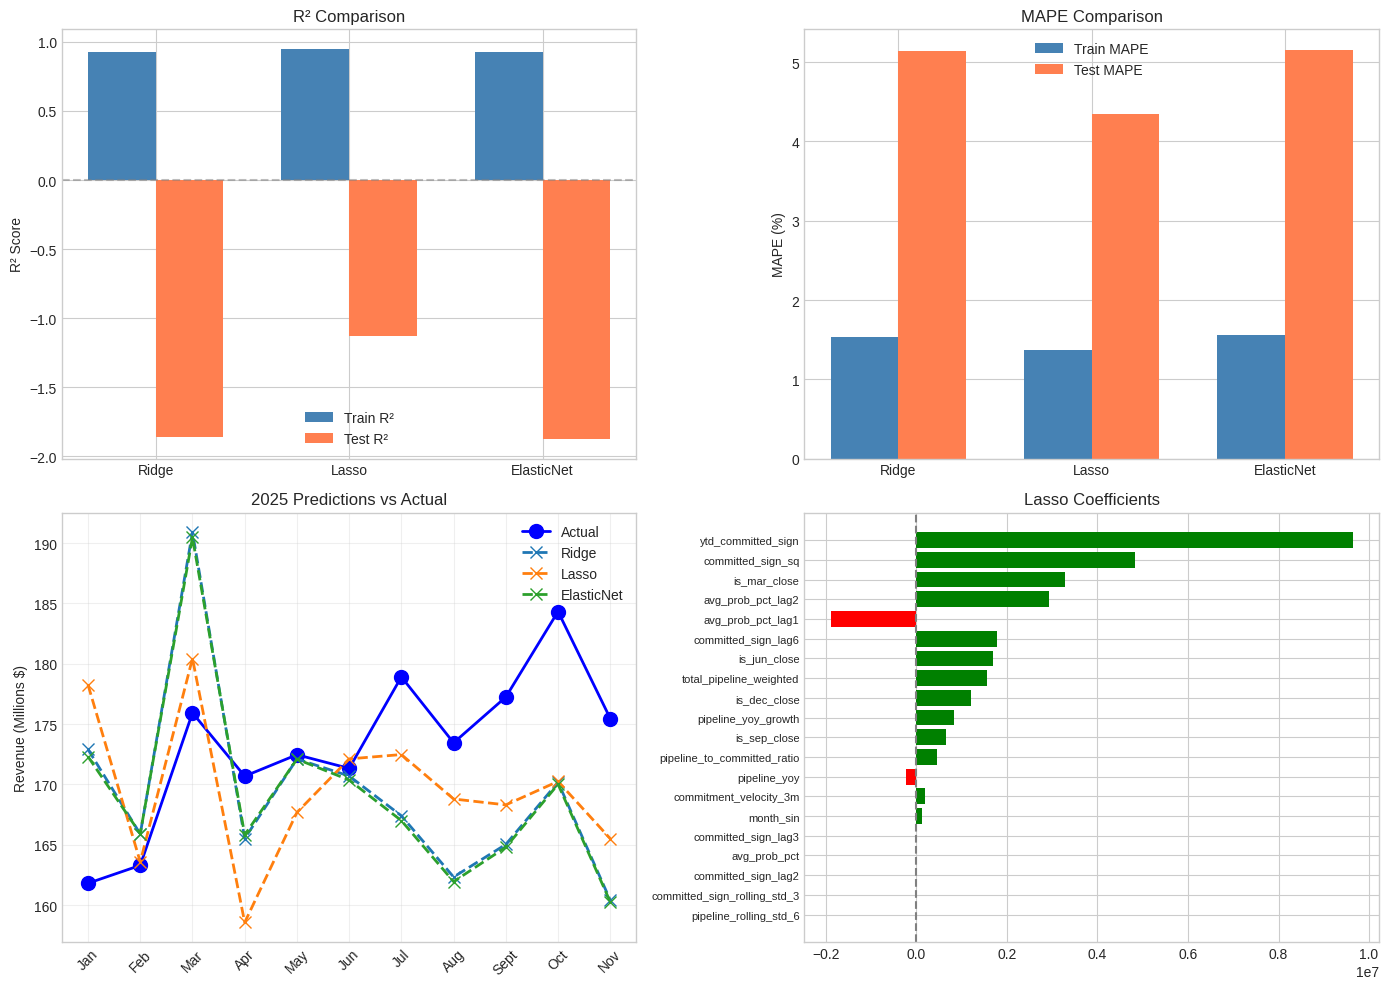

In [22]:
# Visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# R² comparison
ax = axes[0, 0]
x = np.arange(len(results))
w = 0.35
ax.bar(x - w/2, [results[m]['train_r2'] for m in results], w, label='Train R²', color='steelblue')
ax.bar(x + w/2, [results[m]['test_r2'] for m in results], w, label='Test R²', color='coral')
ax.set_xticks(x)
ax.set_xticklabels(results.keys())
ax.set_ylabel('R² Score')
ax.set_title('R² Comparison')
ax.legend()
ax.axhline(0, color='gray', ls='--', alpha=0.5)

# MAPE comparison
ax = axes[0, 1]
ax.bar(x - w/2, [results[m]['train_mape'] for m in results], w, label='Train MAPE', color='steelblue')
ax.bar(x + w/2, [results[m]['test_mape'] for m in results], w, label='Test MAPE', color='coral')
ax.set_xticks(x)
ax.set_xticklabels(results.keys())
ax.set_ylabel('MAPE (%)')
ax.set_title('MAPE Comparison')
ax.legend()

# Predictions
ax = axes[1, 0]
months = test_data['month'].values
ax.plot(range(len(y_test)), y_test.values/1e6, 'bo-', label='Actual', lw=2, ms=10)
for n, r in results.items():
    ax.plot(range(len(y_test)), r['y_pred']/1e6, 'x--', label=n, lw=2, ms=8)
ax.set_xticks(range(len(months)))
ax.set_xticklabels(months, rotation=45)
ax.set_ylabel('Revenue (Millions $)')
ax.set_title('2025 Predictions vs Actual')
ax.legend()
ax.grid(True, alpha=0.3)

# Coefficients (best model)
ax = axes[1, 1]
coefs = pd.Series(results[best]['model'].coef_, index=selected).sort_values(key=abs, ascending=True)
colors = ['green' if c > 0 else 'red' for c in coefs.values]
ax.barh(range(len(coefs)), coefs.values, color=colors)
ax.set_yticks(range(len(coefs)))
ax.set_yticklabels(coefs.index, fontsize=8)
ax.set_title(f'{best} Coefficients')
ax.axvline(0, color='gray', ls='--')

plt.tight_layout()
plt.show()

In [23]:
# Predictions table
print("\n" + "="*70)
print("DETAILED PREDICTIONS - 2025")
print("="*70)

pred_df = pd.DataFrame({
    'Month': test_data['month'].values,
    'Actual ($M)': (y_test.values / 1e6).round(2),
    'Ridge ($M)': (results['Ridge']['y_pred'] / 1e6).round(2),
    'Lasso ($M)': (results['Lasso']['y_pred'] / 1e6).round(2),
    'ElasticNet ($M)': (results['ElasticNet']['y_pred'] / 1e6).round(2)
})
pred_df['Ridge Err%'] = ((results['Ridge']['y_pred'] - y_test.values) / y_test.values * 100).round(2)
pred_df['Lasso Err%'] = ((results['Lasso']['y_pred'] - y_test.values) / y_test.values * 100).round(2)
pred_df['EN Err%'] = ((results['ElasticNet']['y_pred'] - y_test.values) / y_test.values * 100).round(2)
print(pred_df.to_string(index=False))


DETAILED PREDICTIONS - 2025
Month  Actual ($M)  Ridge ($M)  Lasso ($M)  ElasticNet ($M)  Ridge Err%  Lasso Err%  EN Err%
  Jan       161.80      172.89      178.25           172.30        6.85       10.16     6.49
  Feb       163.29      165.88      163.57           165.92        1.59        0.17     1.61
  Mar       175.93      190.89      180.43           190.46        8.51        2.56     8.26
  Apr       170.68      165.51      158.56           165.81       -3.03       -7.10    -2.85
  May       172.46      172.10      167.67           172.09       -0.21       -2.77    -0.21
  Jun       171.32      170.70      172.11           170.36       -0.37        0.46    -0.56
  Jul       178.91      167.40      172.47           167.00       -6.43       -3.60    -6.66
  Aug       173.45      162.32      168.79           161.94       -6.41       -2.69    -6.63
 Sept       177.24      165.02      168.30           164.79       -6.89       -5.04    -7.02
  Oct       184.32      170.18      170.2

In [24]:
# Export
print("\n" + "="*70)
print("EXPORT RESULTS")
print("="*70)

# Model metrics
metrics = []
for n, r in results.items():
    metrics.append({
        'model_type': n.lower(), 'r2_train': r['train_r2'], 'r2_test': r['test_r2'],
        'mae': r['test_mae'], 'mape': r['test_mape'], 'alpha': r['alpha'],
        'l1_ratio': r.get('l1_ratio'), 'is_best_model': n == best
    })
pd.DataFrame(metrics).to_csv('model_metrics.csv', index=False)
print("✓ model_metrics.csv")

# Feature importance
fi = []
for n, r in results.items():
    coefs = pd.Series(r['model'].coef_, index=selected)
    for rank, (f, c) in enumerate(coefs.abs().sort_values(ascending=False).items(), 1):
        fi.append({'model_type': n.lower(), 'feature_name': f, 'coefficient': coefs[f], 'abs_coefficient': c, 'rank': rank})
pd.DataFrame(fi).to_csv('feature_importance.csv', index=False)
print("✓ feature_importance.csv")

# Predictions
preds = []
for n, r in results.items():
    for i, (idx, actual) in enumerate(y_test.items()):
        pred = r['y_pred'][i]
        preds.append({'model_type': n.lower(), 'revenue_data_id': idx, 'predicted_revenue': pred,
                      'prediction_error': pred - actual, 'percentage_error': (pred - actual)/actual*100})
pd.DataFrame(preds).to_csv('predictions.csv', index=False)
print("✓ predictions.csv")

# Revenue data
rev = df_imputed[['year', 'month', 'month_num_parsed', 'actual_revenue', 'wtd_pipeline_revenue',
                   'committed_unsig_revenue', 'committed_sign_revenue', 'avg_prob_pct']].copy()
rev.columns = ['year', 'month_name', 'month', 'actual_revenue', 'wtd_pipeline', 'committed_unsigned',
               'committed_signed', 'human_forecast']
rev['total_committed'] = rev['committed_signed'] + rev['committed_unsigned']
rev['is_actual'] = rev['year'].isin([2023, 2024])
rev.to_csv('revenue_data.csv', index=False)
print("✓ revenue_data.csv")


EXPORT RESULTS
✓ model_metrics.csv
✓ feature_importance.csv
✓ predictions.csv
✓ revenue_data.csv


---
## FINAL SUMMARY

In [25]:
print("="*70)
print("FINAL SUMMARY")
print("="*70)

print("\n📊 PIPELINE:")
print("  1. ✅ Data Loading")
print("  2. ✅ Advanced Imputation (DECREASING cumulative columns)")
print("  3. ✅ Feature Engineering (all requested features)")
print("  4. ✅ Multicollinearity Removal")
print("  5. ✅ Feature Selection (Ensemble: 4 methods)")
print("  6. ✅ Model Training (Ridge, Lasso, ElasticNet)")

print(f"\n📋 DATA: Train={len(train_data)} (2023-24), Test={len(test_data)} (2025)")
print(f"\n📋 FEATURES ({len(selected)}): {selected[:5]}...")

print("\n🏆 RESULTS:")
for n, r in results.items():
    s = "✅" if r['test_r2'] > 0 else "⚠️"
    print(f"  {s} {n}: R²={r['test_r2']:.4f}, MAPE={r['test_mape']:.2f}%")

print(f"\n🏆 BEST: {best} (R²={results[best]['test_r2']:.4f})")

print("\n📁 EXPORTS: model_metrics.csv, feature_importance.csv, predictions.csv, revenue_data.csv")

print("\n" + "="*70)
print("NOTEBOOK COMPLETE")
print("="*70)

FINAL SUMMARY

📊 PIPELINE:
  1. ✅ Data Loading
  2. ✅ Advanced Imputation (DECREASING cumulative columns)
  3. ✅ Feature Engineering (all requested features)
  4. ✅ Multicollinearity Removal
  5. ✅ Feature Selection (Ensemble: 4 methods)
  6. ✅ Model Training (Ridge, Lasso, ElasticNet)

📋 DATA: Train=22 (2023-24), Test=11 (2025)

📋 FEATURES (20): ['total_pipeline_weighted', 'committed_sign_lag6', 'avg_prob_pct_lag2', 'ytd_committed_sign', 'committed_sign_sq']...

🏆 RESULTS:
  ⚠️ Ridge: R²=-1.8628, MAPE=5.14%
  ⚠️ Lasso: R²=-1.1277, MAPE=4.35%
  ⚠️ ElasticNet: R²=-1.8748, MAPE=5.16%

🏆 BEST: Lasso (R²=-1.1277)

📁 EXPORTS: model_metrics.csv, feature_importance.csv, predictions.csv, revenue_data.csv

NOTEBOOK COMPLETE


# Task
Create a figure with three subplots. Each subplot will display 'actual_revenue' and one of the following revenue types: 'wtd_pipeline_revenue', 'committed_unsig_revenue', or 'committed_sign_revenue'. Plot these variables over time using line plots to visualize their temporal behavior and potential correlations.

## Generate visualization

### Subtask:
Create a figure with multiple subplots. Each subplot will display 'actual_revenue' and one of the specified revenue types ('wtd_pipeline_revenue', 'committed_unsig_revenue', 'committed_sign_revenue') over time using line plots. This helps in understanding their temporal behavior and potential correlations.


## Summary:

The next step in the analysis involves generating a visualization. A figure with three subplots will be created to display 'actual\_revenue' alongside 'wtd\_pipeline\_revenue', 'committed\_unsig\_revenue', and 'committed\_sign\_revenue' respectively. These variables will be plotted over time using line plots to visualize their temporal behavior and potential correlations.


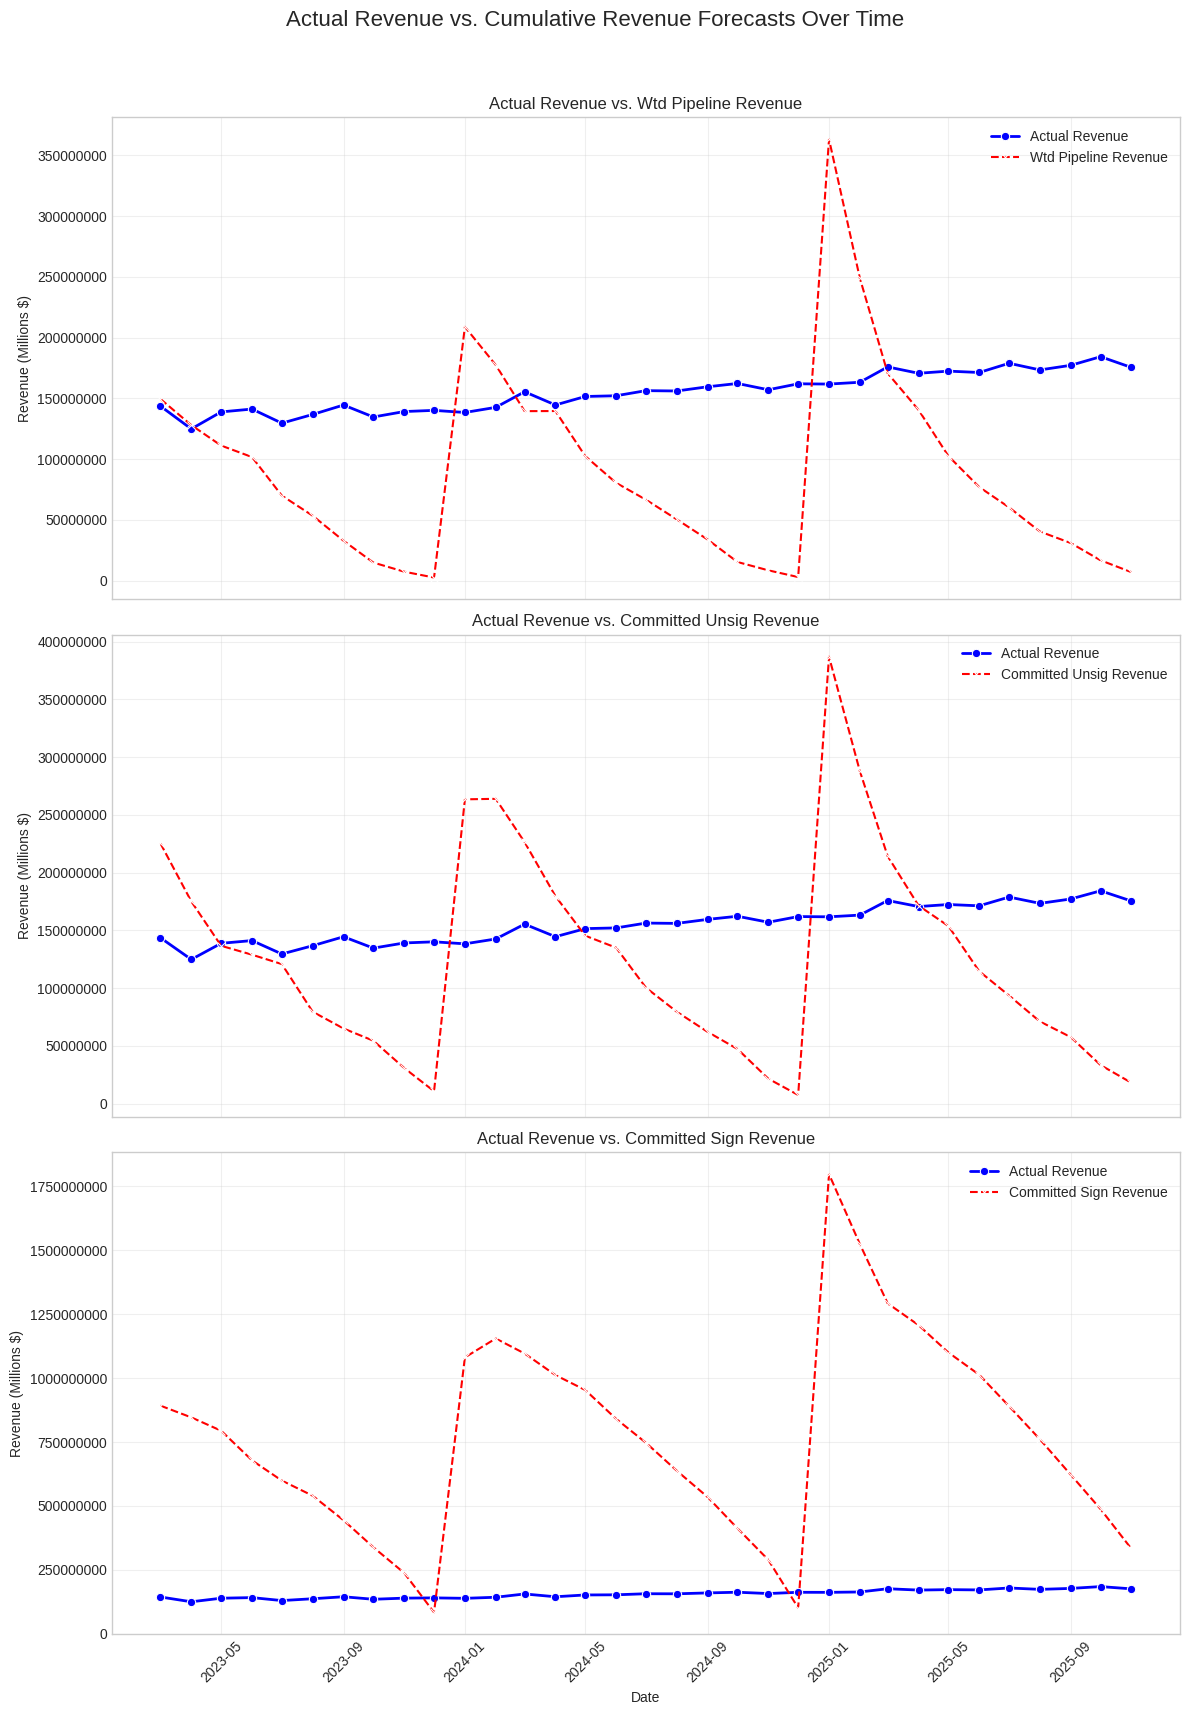

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-v0_8-whitegrid')

# Prepare data for plotting
plot_df = df_imputed.copy()
plot_df['date'] = pd.to_datetime(plot_df['year'].astype(str) + '-' + plot_df['month_num_parsed'].astype(str) + '-01')
plot_df = plot_df.sort_values('date').reset_index(drop=True)

cumulative_cols = ['wtd_pipeline_revenue', 'committed_unsig_revenue', 'committed_sign_revenue']

fig, axes = plt.subplots(3, 1, figsize=(12, 18), sharex=True)
fig.suptitle('Actual Revenue vs. Cumulative Revenue Forecasts Over Time', fontsize=16)

for i, col in enumerate(cumulative_cols):
    ax = axes[i]
    sns.lineplot(data=plot_df, x='date', y='actual_revenue', marker='o', ax=ax, label='Actual Revenue', color='blue', linewidth=2)
    sns.lineplot(data=plot_df, x='date', y=col, marker='x', ax=ax, label=col.replace('_', ' ').title(), color='red', linestyle='--', linewidth=1.5)
    ax.set_title(f'Actual Revenue vs. {col.replace('_', ' ').title()}')
    ax.set_ylabel('Revenue (Millions $)')
    ax.ticklabel_format(style='plain', axis='y') # Prevent scientific notation on y-axis
    ax.legend()
    ax.grid(True, alpha=0.3)

axes[-1].set_xlabel('Date')
plt.xticks(rotation=45)
plt.tight_layout(rect=[0, 0.03, 1, 0.96]) # Adjust layout to prevent suptitle from overlapping
plt.show()